In [1]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [3]:
df = pd.read_csv(r'C:\Users\Garvit bhalse\Downloads\JSWSTEEL\Quote-Equity-JSWSTEEL-EQ-01-01-2024-to-01-01-2025.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Value,No of trades
0,31-Dec-24,898.05,906.4,896.6,901.5,"10,31,176","92,98,52,355.85","32,730"
1,30-Dec-24,913.3,916.7,895.6,898.95,"19,59,379","1,77,29,23,796.85","69,037"
2,27-Dec-24,914.65,926.5,911.25,913.3,"19,17,836","1,75,75,54,068.45","57,701"
3,26-Dec-24,921.85,929.4,913.1,914.45,"20,56,005","1,88,89,70,215.25","49,000"
4,24-Dec-24,937.05,937.95,918.45,921.85,"20,48,135","1,89,62,52,318.55","66,439"


In [4]:
# Clean column names
df.columns = df.columns.str.strip()
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value',
       'No of trades'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          249 non-null    object
 1   Open          249 non-null    object
 2   High          249 non-null    object
 3   Low           249 non-null    object
 4   Close         249 non-null    object
 5   Volume        249 non-null    object
 6   Value         249 non-null    object
 7   No of trades  249 non-null    object
dtypes: object(8)
memory usage: 15.7+ KB


In [6]:
# Convert 'Date' to datetime and set as the index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)
df.head()

C:\Users\Garvit bhalse\AppData\Local\Temp\ipykernel_3260\523789710.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


,Open,High,Low,Close,Volume,Value,No of trades
Date,,,,,,,
2024-12-31,898.05,906.4,896.6,901.5,"10,31,176","92,98,52,355.85","32,730"
2024-12-30,913.3,916.7,895.6,898.95,"19,59,379","1,77,29,23,796.85","69,037"
2024-12-27,914.65,926.5,911.25,913.3,"19,17,836","1,75,75,54,068.45","57,701"
2024-12-26,921.85,929.4,913.1,914.45,"20,56,005","1,88,89,70,215.25","49,000"
2024-12-24,937.05,937.95,918.45,921.85,"20,48,135","1,89,62,52,318.55","66,439"


In [7]:
# Convert numeric columns to proper data types
for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'No of trades']:
    df[col] = pd.to_numeric(df[col].str.replace(',', '').str.strip(), errors='coerce')

# Drop rows with NaN
df.dropna(inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2024-12-31 to 2024-01-01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          249 non-null    float64
 1   High          249 non-null    float64
 2   Low           249 non-null    float64
 3   Close         249 non-null    float64
 4   Volume        249 non-null    int64  
 5   Value         249 non-null    object 
 6   No of trades  249 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 15.6+ KB


,Open,High,Low,Close,Volume,Value,No of trades
Date,,,,,,,
2024-12-31,898.05,906.40,896.60,901.50,1031176,"92,98,52,355.85",32730
2024-12-30,913.30,916.70,895.60,898.95,1959379,"1,77,29,23,796.85",69037
2024-12-27,914.65,926.50,911.25,913.30,1917836,"1,75,75,54,068.45",57701
2024-12-26,921.85,929.40,913.10,914.45,2056005,"1,88,89,70,215.25",49000
2024-12-24,937.05,937.95,918.45,921.85,2048135,"1,89,62,52,318.55",66439


In [8]:
df.isnull().sum().sum()

0

In [9]:
df.shape

(249, 7)

In [10]:
df.size

1743

In [11]:
df.nunique()

Open            224
High            237
Low             236
Close           243
Volume          249
Value           249
No of trades    249
dtype: int64

In [12]:
df.describe()

,Open,High,Low,Close,Volume,No of trades
count,249.000000,249.000000,249.000000,249.000000,2.490000e+02,249.000000
mean,905.459839,915.383534,893.075904,904.087751,2.364089e+06,85661.755020
std,63.655627,64.396250,63.502532,63.931238,2.094682e+06,37813.703964
min,780.650000,790.200000,761.750000,780.650000,1.365080e+05,8643.000000
25%,846.100000,863.600000,834.400000,844.950000,1.441218e+06,59058.000000
50%,911.950000,920.850000,900.100000,912.150000,1.926448e+06,75989.000000
75%,950.400000,960.950000,939.050000,949.850000,2.725373e+06,105234.000000
max,1042.000000,1063.000000,1027.300000,1039.100000,2.900334e+07,222180.000000


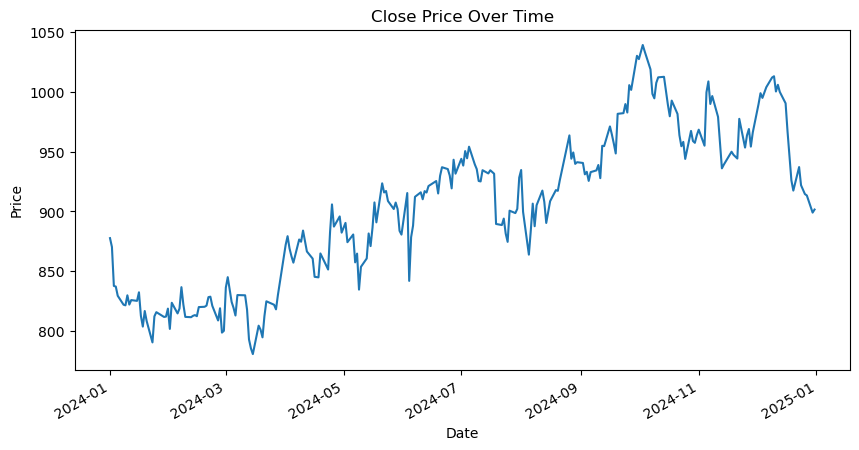

In [13]:
df['Close'].plot(figsize=(10, 5), title='Close Price Over Time', ylabel='Price')
plt.show()

In [14]:
result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("The series is not stationary. Differencing is required.")
else:
    print("The series is stationary")

ADF Statistic: -1.5871148440473588
p-value: 0.49006286365205376
The series is not stationary. Differencing is required.


In [15]:
df['Close_diff'] = df['Close'].diff()

result_diff = adfuller(df['Close_diff'].dropna())
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

if result_diff[1] > 0.05:
    print("The series is still not stationary. Additional differencing required")
else:
    print("The series is now stationary")

ADF Statistic (Differenced): -18.319161570849985
p-value (Differenced): 2.267720407153852e-30
The series is now stationary


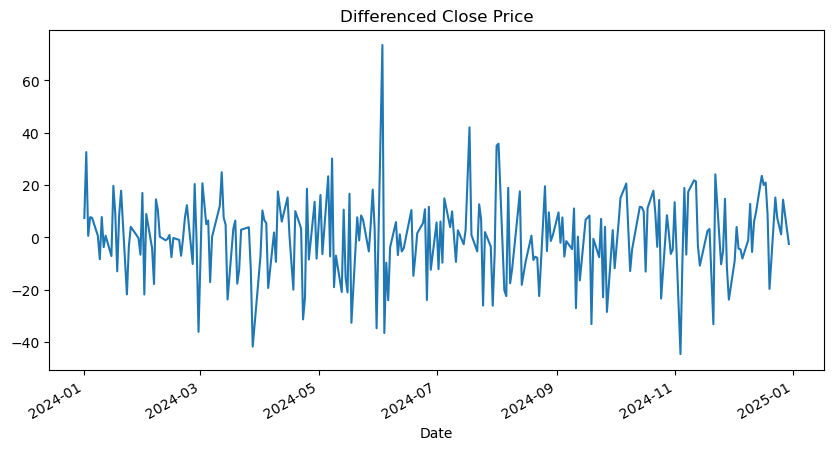

In [16]:
df['Close_diff'].plot(figsize=(10, 5), title='Differenced Close Price')
plt.show()

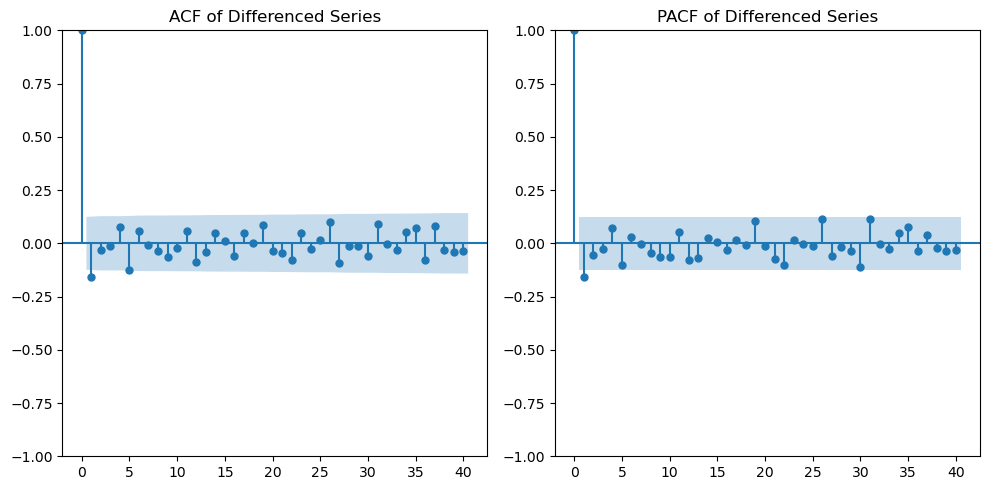

In [17]:
# Plot ACF and PACF for the differenced "Close" price
plt.figure(figsize=(10, 5))

# ACF plot
plt.subplot(121)
plot_acf(df['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF of Differenced Series')

# PACF plot
plt.subplot(122)
plot_pacf(df['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF of Differenced Series')

plt.tight_layout()
plt.show()

In [18]:
# List of columns to calculate correlation with 'Close'
columns_to_correlate = ['No of trades', 'Volume', 'High', 'Low']

# Calculate and display correlation for each column
for col in columns_to_correlate:
    correlation = df['Close'].corr(df[col])
    print(f"Correlation coefficient between 'Close' and '{col}': {correlation:.2f}")

Correlation coefficient between 'Close' and 'No of trades': -0.17
Correlation coefficient between 'Close' and 'Volume': -0.01
Correlation coefficient between 'Close' and 'High': 0.99
Correlation coefficient between 'Close' and 'Low': 0.99


In [19]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(df['Close'],
                             seasonal=True,
                             m=12,  # Monthly seasonality
                             d=1,   # Regular differencing
                             D=0,    # Seasonal differencing
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2060.743, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2060.245, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2055.993, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2055.239, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2058.255, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2055.505, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2057.020, Time=0.21 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2057.111, Time=0.33 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2055.349, Time=0.12 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=2059.018, Time=0.62 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2060.068, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2056.914, Time=0.24 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=2056.941, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2055.876, Time=0.11 sec
 ARIMA(1,1,2)(0,0,1

In [20]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(df['Close'],
                             seasonal=True,
                             m=12,  # Monthly seasonality
                             d=1,   # Regular differencing
                             D=1,    # Seasonal differencing
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2145.851, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2069.522, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2141.289, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2047.592, Time=0.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2054.889, Time=0.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2047.779, Time=0.31 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=2048.243, Time=0.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2046.345, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2068.619, Time=0.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-

Mean Absolute Error (MAE): 6.266615527852484
Root Mean Squared Error (RMSE): 7.804674017616519
Mean Squared Error (MSE): 60.91293652125838


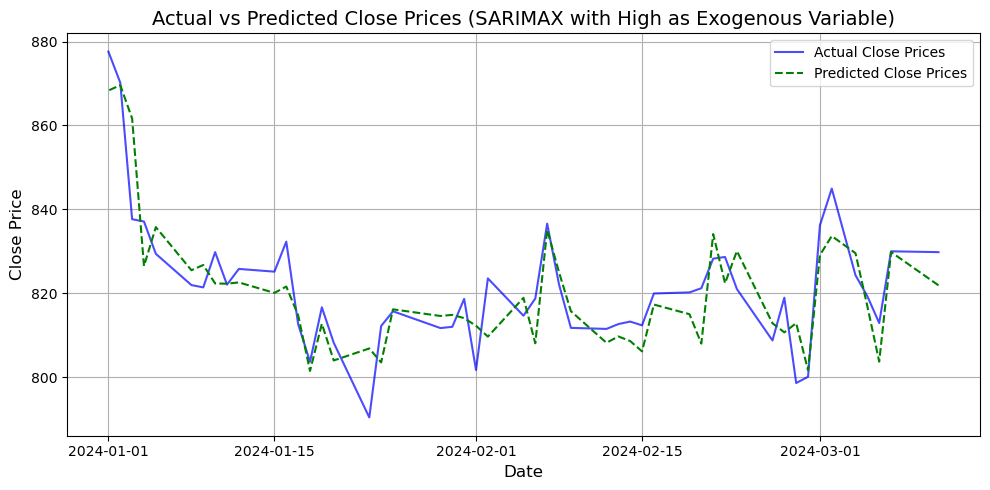

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure Close and High are numeric
df['Close'] = pd.to_numeric(df['Close'])
df['High'] = pd.to_numeric(df['High'])

# Define the target variable (Close) and the exogenous variable (High)
y = df['Close']
X = df[['High']]  # Exogenous variable should be a DataFrame

# Split the data into training and testing sets (80/20 split)
train_size = int(len(df) * 0.8)
train_y, test_y = y[:train_size], y[train_size:]
train_X, test_X = X[:train_size], X[train_size:]

# Build the SARIMAX model using the best parameters identified
sarimax_model = SARIMAX(
    train_y,
    exog=train_X,
    order=(0, 1, 1),
    seasonal_order=(2, 1, 0, 12)
)

# Fit the model
sarimax_result = sarimax_model.fit(disp=False)

# Generate predictions for the test set
predictions = sarimax_result.get_forecast(steps=len(test_y), exog=test_X)

# Extract predicted values
predicted_values = predictions.predicted_mean

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, predicted_values)
rmse = np.sqrt(mean_squared_error(test_y, predicted_values))
mse = mean_squared_error(test_y, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")

# Plotting actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_y.index, test_y, label='Actual Close Prices', color='blue', alpha=0.7)
plt.plot(test_y.index, predicted_values, label='Predicted Close Prices', color='green', linestyle='--')
plt.title('Actual vs Predicted Close Prices (SARIMAX with High as Exogenous Variable)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-

Mean Absolute Error (MAE): 9.727019692284719
Root Mean Squared Error (RMSE): 11.799975384945045
Mean Squared Error (MSE): 139.23941908530895


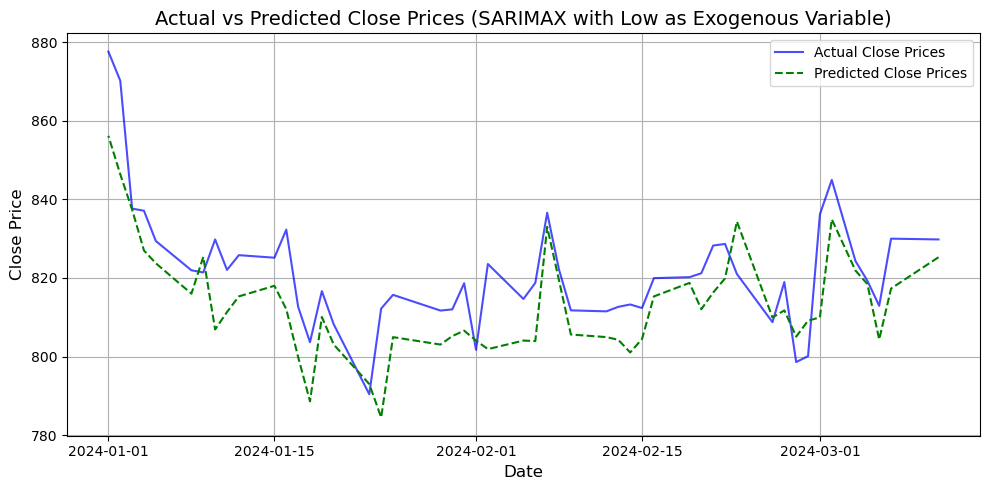

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure Close and Low are numeric
df['Close'] = pd.to_numeric(df['Close'])
df['Low'] = pd.to_numeric(df['Low'])

# Define the target variable (Close) and the exogenous variable (Low)
y = df['Close']
X = df[['Low']]  # Exogenous variable should be a DataFrame

# Split the data into training and testing sets (80/20 split)
train_size = int(len(df) * 0.8)
train_y, test_y = y[:train_size], y[train_size:]
train_X, test_X = X[:train_size], X[train_size:]

# Build the SARIMAX model
sarimax_model = SARIMAX(
    train_y,
    exog=train_X,
    order=(0, 1, 1),
    seasonal_order=(2, 1, 0, 12)
)

# Fit the model
sarimax_result = sarimax_model.fit(disp=False)

# Generate predictions for the test set
predictions = sarimax_result.get_forecast(steps=len(test_y), exog=test_X)

# Extract predicted values
predicted_values = predictions.predicted_mean

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, predicted_values)
rmse = np.sqrt(mean_squared_error(test_y, predicted_values))
mse = mean_squared_error(test_y, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")

# Plotting actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_y.index, test_y, label='Actual Close Prices', color='blue', alpha=0.7)
plt.plot(test_y.index, predicted_values, label='Predicted Close Prices', color='green', linestyle='--')
plt.title('Actual vs Predicted Close Prices (SARIMAX with Low as Exogenous Variable)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()